<h1><center>Résistance des matériaux (GMC-2001) - Étude de cas H24</center></h1>
<hr>
<br><br>

**Membres de l'équipe**
| Nom | NI |
| --- | :---: |
| Zachary Gauthier | 536 886 831 |
| Antoine Reid | 536 899 522 |
| Maxime Tousignant-Tremblay | 536 772 369 |

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import cumulative_trapezoid
from shapely import Polygon

%matplotlib inline
%config InlineBackend.figure_formats = "svg",
plt.style.use("LabReport.mplstyle")

# Données du problème

In [2]:
L = 1.51 # Longueur de l'aile
cp = 0.34 # Corde au "bout" de l'aile
cr = 0.606 # Corde à la jonction avec le fuselage
t = 0.35e-3 # Épaisseur du revêtement

# Fibre de carbone
yc_rev = 0.046128
sig_rup_txy_cf = 800e6
sig_rup_cxy_cf = 700e6
sig_rup_tau_cf = 130e6

# Polystyrène
yc_coeur = 0.053017
xc_coeur = 0.40575
sig_rup_t_poly = 500e3
sig_rup_tau_poly = 600e3

# Charger les données fournises

Rappel : $z$ représente la position le long de l'aile

In [3]:
# Charger les données de chargement aérodynamique
z, w_raw = np.loadtxt("data/lift.txt", skiprows=1, unpack=True)

# Considérer le facteur de charge de 3
w = w_raw * 1

# Charger les données du profil normalisé
x, y = np.loadtxt("data/MH114.txt", skiprows=1, unpack=True)

# Tracer la géométrie du problème

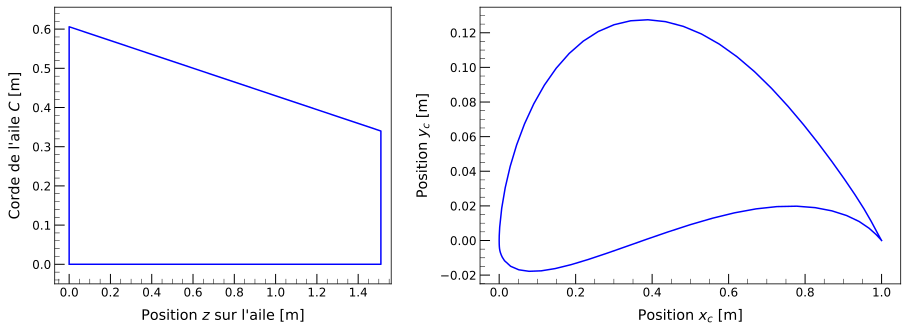

In [4]:
# Définir les sommets du trapèze avec la grande base verticale
vertices = np.asarray(
    (
        (0, 0),
        (L, 0),
        (L, cp),
        (0, cr),
        (0, 0),
    )
)

# Extraire les coordonnées x et y des sommets
l_pts = vertices[:, 0]
c_pts = vertices[:, 1]

# Générer les axes avec des ratios de largeur spécifique
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(13, 5), gridspec_kw={'width_ratios': (2, 2.5)})

# Tracer les arêtes du trapèze
ax0.plot(l_pts, c_pts, "b")
ax0.set_xlim(-0.07, L + 0.05)
ax0.set_ylim(-0.05, max(cp, cr) + 0.05)
ax0.set_xlabel("Position $z$ sur l'aile [m]")
ax0.set_ylabel("Corde de l'aile $C$ [m]")

# Tracer le profil transversal de l'aile
ax1.plot(x, y, "b")
ax1.set_xlabel("Position $x_c$ [m]")
ax1.set_ylabel("Position $y_c$ [m]")

# Ajouter de l'espace horizontal entre les graphiques
plt.tight_layout(pad=2)

# Enregistrer le graphique
# plt.savefig("plots/profil")

# Afficher le graphique
plt.show()

# Tracer le chargement aérodynamique en fonction de la position sur la longueur *L* de l'aile

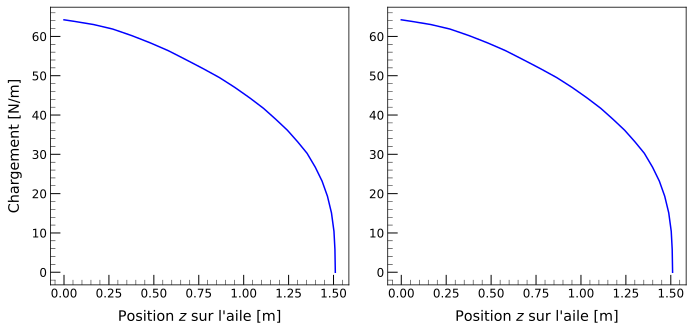

In [5]:
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))

ax0.plot(z, w_raw, "b")
ax0.set_xlabel("Position $z$ sur l'aile [m]")
ax0.set_ylabel("Chargement [N/m]")

ax1.plot(z, w, "b")
ax1.set_xlabel("Position $z$ sur l'aile [m]")

plt.tight_layout(pad=2)
# plt.savefig("plots/lift")
plt.show()

# Calcul de la réaction à $z=0$

In [6]:
# Calcul du centre de masse du chargement
# z_cm = np.trapz(w * pos, pos) / np.trapz(w, pos)

# Calcul de la force totale
F_total = np.trapz(w, z)

# Calcul de V0 et M0
V0 = F_total
#M0 = F_total * L

# print(f"Centre de masse du chargement: {z_cm:.2f} m")
print(f"Force totale: {F_total:.2f} N")
print(f"V0: {V0:.2f} N")
print(f"M0: {M0:.2f} Nm")

Force totale: 74.08 N
V0: 74.08 N


NameError: name 'M0' is not defined

# Calcul des moments en tout points $z$ sur l'aile

On calcul le moment fléchissant en intégrant le chargement par rapport à la position. La fonction cumulative_trapezoid fournit une intégration numérique par la méthode des trapèzes, donc nous l'utilisons deux fois pour passer du chargement au moment.

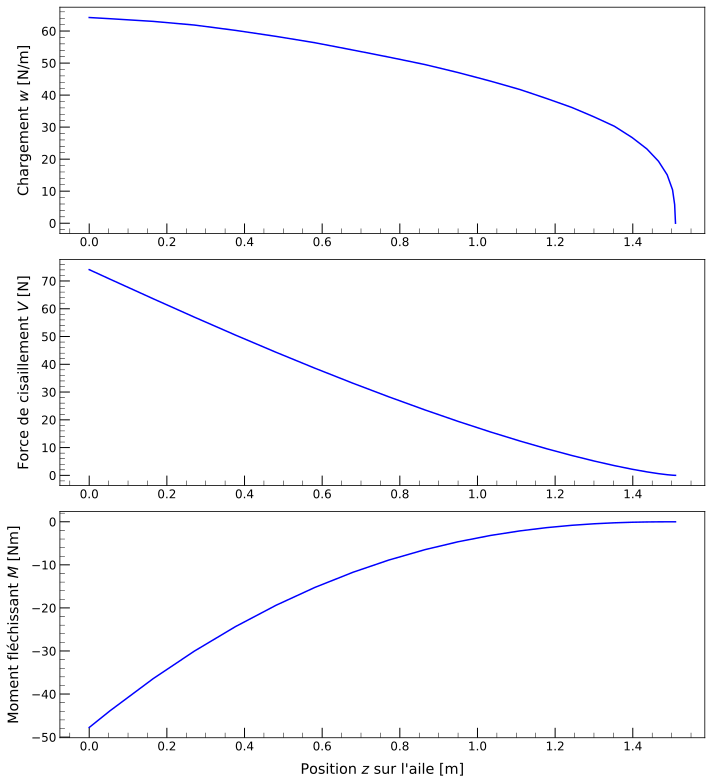

In [ ]:
Vz = cumulative_trapezoid(-w, z, initial=0) + V0

M0 = np.trapz(Vz, z)
M = cumulative_trapezoid(Vz, z, initial=0) - M0

# Tracer le chargement et le moment fléchissant pour visualiser
_, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 11))

# Chargement aérodynamique
ax1.plot(z, w, "b", label="Chargement aérodynamique [N/m]")
ax1.set_ylabel("Chargement $w$ [N/m]")

# Effort tranchant
ax2.plot(z, Vz, "b", label="Effort tranchant [N]")
ax2.set_ylabel("Force de cisaillement $V$ [N]")

# Moment fléchissant
ax3.plot(z, M, "b", label="Moment fléchissant [N·m]")
ax3.set_xlabel("Position $z$ sur l'aile [m]")
ax3.set_ylabel("Moment fléchissant $M$ [Nm]")

# plt.savefig("plots/forces")
plt.show()

# Fonctions de calcul

In [ ]:
def corde(pos):
    """Calcul la corde de l'aile à un z donné."""
    dz = (cp - cr) / L
    return dz * pos + 0.606


def k(pos):
    """Coefficient de proporitonnalité le long de z."""
    return corde(pos) / corde(0)


def aire(pos):
    """Calcul la projection de l'aire d'une section sur z.

    Si une position varie linéairement par un facteur k,
    l'aire varie linéairement par un facteur k^2. La formule
    de l'aire est tirée de l'énoncé du travail.

    """
    return 0.0851101 * corde(pos)**2


def delta_pos(p, pos):
    """Calcul la projection d'un point à une position z donnée.

    Comme la géométrie du problème varie le long de l'aile, un point
    à une position z quelconque se déplace relativement au centroïde.
    Les points à z = 0 vont se rapprocher graduellement du centre à
    mesure qu'on s'éloigne de la jonction du fuselage.

    """
    return p * corde(pos) / cr


def axes_paralleles(I, pos):
    """Applique le théorème des axes parallèles sur un moment I."""
    return I + aire(pos) * pos**2


def inertie_rev(pos):
    """Calcul du moment d'inertie du revêtement."""
    Ix = 0.0051752 * t * corde(pos)**3
    #Itot = axes_paralleles(Ix, pos)
    return Ix


def inertie_coeur(pos):
    """Calcul du moment d'inertie du coeur."""
    Ix = 9.8490e-5 * corde(pos)**4
    #Itot = axes_paralleles(Ix, pos)
    return Ix 


# Calcul des moments d'inertie

Les moments d'inerties sont calculés d'après les formules de l'énoncé. On a :
\begin{gather*}
    I_{x,rev} = 0,0051752\,c(z)^3t \\
    I_{x,coeur} = 9,849\left(10\right)^{-5}c(z)^4
\end{gather*}

In [ ]:
# Inertie du coeur [m^4]
Icoeur = inertie_coeur(z)

# Inertie du revêtement [m^4]
Irev = inertie_rev(z)

# Coeur de l'aile

## Calcul du premier moment de l'aire du profil $Q$

Puisque la série de donnée donne le contour, on a plusieurs y pour un seul x. On ne peut donc pas intégrer directement pour obtenir l'aire supérieure. Cependant, la partie inéfieure forme une parabole qui ne revient pas sur elle même. On peut ainsi soustraire l'intégrale de cette courbe à l'aire totale pour avoir l'aire supérieure.

In [ ]:
"""

# Position du centroïde de l'aire A par rapport à l'axe neutre
yc = y.max() / 2

# Variation de yc avec z
yc_z = delta_pos(yc, z)

# Découper la parabole inférieure
lim = np.argmin(np.abs(x))
mask = np.where(y < 0)
y_inf = y[y < 0]
x_inf = x[y < 0]

# Intégrer pour trouver l'aire inférieure et propager le long de z
a_inf = np.trapz(y_inf, x_inf) * k(z)**2

# Calculer l'aire supérieure
a_sup = aire(z) + a_inf

# Premier moment d'aire
Q = yc_z * a_sup


# Tracer la partie inférieure pour visualiser
plt.plot(x_inf, -y_inf, "b")
plt.xlabel("Position $x_c$ normalisée")
plt.ylabel("Position $y_c$ normalisée")
plt.show()

"""

'\n\n# Position du centroïde de l\'aire A par rapport à l\'axe neutre\nyc = y.max() / 2\n\n# Variation de yc avec z\nyc_z = delta_pos(yc, z)\n\n# Découper la parabole inférieure\nlim = np.argmin(np.abs(x))\nmask = np.where(y < 0)\ny_inf = y[y < 0]\nx_inf = x[y < 0]\n\n# Intégrer pour trouver l\'aire inférieure et propager le long de z\na_inf = np.trapz(y_inf, x_inf) * k(z)**2\n\n# Calculer l\'aire supérieure\na_sup = aire(z) + a_inf\n\n# Premier moment d\'aire\nQ = yc_z * a_sup\n\n\n# Tracer la partie inférieure pour visualiser\nplt.plot(x_inf, -y_inf, "b")\nplt.xlabel("Position $x_c$ normalisée")\nplt.ylabel("Position $y_c$ normalisée")\nplt.show()\n\n'

In [ ]:
# Points de la partie supérieure à l'axe neutre
x_sup = x[y > yc_coeur]
y_sup = y[y > yc_coeur]

polygon = Polygon(zip(x_sup, y_sup))

# Aire de la partie supérieure à l'axe neutre le long de la corde
area_sup = polygon.area*corde(z)**2

# distance entre le centroïde de la partie supérieure et l'axe neutre
neutral_axis_distance = abs(float(polygon.centroid.y) - yc_coeur) * corde(z)

# Q maximal le long de la corde
Q = area_sup*neutral_axis_distance
# largeur de l'aire à l'axe neutre
b = (x_sup.max() - x_sup.min())*corde(z)

#plt.plot(z, Q)


## Calcul de la contrainte de cisaillement $\tau$ du coeur en fonction de $z$

Facteur de sécurité du coeur en cisaillement : 189.792


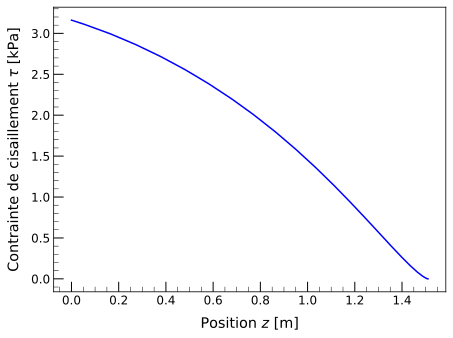

In [ ]:
tau = Vz * Q / (Icoeur * b)

# FS du coeur pour contraintes normales
FS_tau = sig_rup_tau_poly / np.abs(tau).max()
print(f"Facteur de sécurité du coeur en cisaillement : {FS_tau:.3f}")

# Tracer des résultats
plt.plot(z, tau * 1e-3, "b")
plt.xlabel("Position $z$ [m]")
plt.ylabel("Contrainte de cisaillement $\\tau$ [kPa]")
# plt.savefig("plots/tau")
plt.show()

# Revêtement de l'aile

## Calcul de la contrainte normal $\sigma$ du revetment en fonction de $z$

Facteur de sécurité du revêtement en compression : 119.796
Facteur de sécurité du revêtement en traction : 174.287


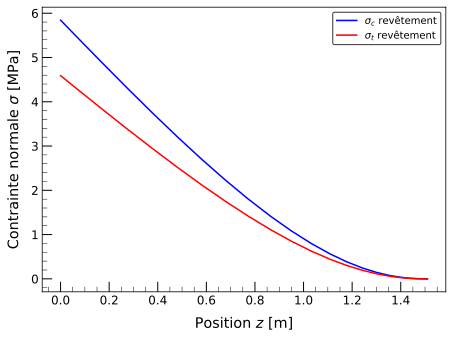

In [ ]:
# Distance max du haut et du bas à l'origine [m]
ymax_0 = y.max()
ymin_0 = y.min()


# Distance max du haut et du bas en fonction de z [m]
#ymax = delta_pos(ymax_0, z)
#ymin = delta_pos(ymin_0, z)
ymax = (ymax_0 - yc_rev) * corde(z)
ymin = (ymin_0 - yc_rev) * corde(z)

# Contraintes normales du coeur [Pa]
sig_c_rev = np.abs(M * ymax) / Irev
sig_t_rev = np.abs(M * ymin) / Irev

# FS du coeur pour contraintes normales
FS_rev_c = sig_rup_cxy_cf / np.abs(sig_c_rev).max()
FS_rev_t = sig_rup_txy_cf / np.abs(sig_t_rev).max()
print(f"Facteur de sécurité du revêtement en compression : {FS_rev_c:.3f}")
print(f"Facteur de sécurité du revêtement en traction : {FS_rev_t:.3f}")

# Tracer des résultats
plt.plot(z, sig_c_rev * 1e-6, "b", label="$\\sigma_c$ revêtement")
plt.plot(z, sig_t_rev * 1e-6, "r", label="$\\sigma_t$ revêtement")
plt.xlabel("Position $z$ [m]")
plt.ylabel("Contrainte normale $\\sigma$ [MPa]")
plt.legend()
# plt.savefig("plots/Sigma")
plt.show()